In [35]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
import pathlib
from pathlib import Path
import requests


# Load the file 
image_path = Path('data/pizza_steak_sushi')
if image_path.is_dir():
    print("File exists")

train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir,test_dir

# Create a transform function
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

# Create the dataset
train_data = datasets.ImageFolder(root = train_dir,
                                 transform=train_transform,
                                 target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=test_transform,
                                 target_transform = None)

train_data,test_data

class_names,class_idx = train_data.classes,train_data.class_to_idx

class_names

# Create dataloader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                            batch_size= BATCH_SIZE,
                            shuffle = False)

train_dataloader,test_dataloader

batch_img,batch_label = next(iter(train_dataloader))

batch_img.shape,batch_label.shape

import torch.nn as nn

# Creating a TinyVGG model
import torch.nn as nn
class TinyVGGModelV0(nn.Module):
    def __init__(self,
                input_shape:int,
                hidden_unit: int,
                output_shape: int):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_unit,
                     kernel_size=  3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size=  3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size=  3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit,
                     out_channels=hidden_unit,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*16*16,
                     out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

img,label = next(iter(train_dataloader))
dummy_model = TinyVGGModelV0(input_shape = 3,
                        hidden_unit=10,
                        output_shape=len(class_names))

dummy_model(img)

!pip install torchinfo
import torchinfo
from torchinfo import summary
summary(dummy_model,input_size=[32,3,64,64])

# Create the train and test loop
def train_loop(data:torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
               accuracy_fn,
              device):

    model.train()

    train_loss,train_acc = 0,0

    for batch, (X,y) in enumerate(data):
        X,y = X.to(device),y.to(device)

        # forward pass
        y_logit = model(X)

        y_pred = torch.softmax(y_logit,dim =1).argmax(dim =1)

        # Calculate loss
        loss = loss_fn(y_logit,y)

        train_loss +=loss.item()

        acc = accuracy_fn(y,
                         y_pred)
        train_acc+=acc

        # set zero grad
        optimizer.zero_grad()

        # Backward propagation
        loss.backward()

        # gradient descent
        optimizer.step()

    train_loss = train_loss/len(data)
    train_acc = train_acc/len(data)


    return train_loss,train_acc

# Create the train and test loop
def test_loop(data:torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn: torch.nn.Module,
               accuracy_fn,
              device):

    model.eval()

    test_loss,test_acc = 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data):
            X,y = X.to(device),y.to(device)
    
            # forward pass
            y_logit = model(X)
    
            y_pred = torch.softmax(y_logit,dim =1).argmax(dim =1)
    
            # Calculate loss
            loss = loss_fn(y_logit,y)
    
            test_loss +=loss.item()
    
            acc = accuracy_fn(y,
                             y_pred)
            test_acc+=acc
    
        test_loss = test_loss/len(data)
        test_acc = test_acc/len(data)
    
    return test_loss,test_acc    
    
    


from tqdm.auto import tqdm
def training(model:torch.nn.Module,
            train_dataloader:torch.utils.data.DataLoader,
            test_dataloader:torch.utils.data.DataLoader,
            loss_fn:torch.nn.Module,
            optimizer: torch.optim.Optimizer,
             accuracy,
             epochs:int,
            device):

    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}
    
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc = train_loop(data = train_dataloader,
                                         model = model,
                                         loss_fn=loss_fn,
                                         optimizer = optimizer,
                                         accuracy_fn=accuracy_fn,
                                         device = device)
        test_loss,test_acc = test_loop(data = test_dataloader,
                                         model = model,
                                         loss_fn=loss_fn,
                                         accuracy_fn=accuracy_fn,
                                         device = device)

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)




    return results

# SEED
torch.manual_seed(42)

# device agnostic code
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

torch.mps.manual_seed(42)

# Create an instance of a model
model_0 = TinyVGGModelV0(input_shape = 3,
                        hidden_unit=20,
                        output_shape=len(class_names)).to(device)


# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(),
                            lr = 0.1)

# Accuracy
from helper_functions import accuracy_fn

# timing
from timeit import default_timer as timer
start_time = timer()

model_0_training = training(model = model_0,
                           train_dataloader=train_dataloader,
                           test_dataloader=test_dataloader,
                           loss_fn = loss_fn,
                           optimizer=optimizer,
                           accuracy=accuracy_fn,
                           epochs = 5,
                           device = device)

File exists


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 5687.6554 | Train acc: 46.4844 | Test Loss: 1.2238 | Test acc: 26.0417
Epoch: 1 | Train Loss: 1.1554 | Train acc: 30.4688 | Test Loss: 1.2387 | Test acc: 26.0417
Epoch: 2 | Train Loss: 1.1546 | Train acc: 30.4688 | Test Loss: 1.1836 | Test acc: 26.0417
Epoch: 3 | Train Loss: 1.1090 | Train acc: 32.4219 | Test Loss: 1.0939 | Test acc: 19.7917
Epoch: 4 | Train Loss: 1.1086 | Train acc: 28.1250 | Test Loss: 1.0851 | Test acc: 54.1667


In [36]:
model_0_training.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [37]:
model_0_training.items()

dict_items([('train_loss', [5687.655367299914, 1.1554002612829208, 1.154581442475319, 1.1090347319841385, 1.1086299866437912]), ('train_acc', [46.484375, 30.46875, 30.46875, 32.421875, 28.125]), ('test_loss', [1.2237751881281536, 1.2387414574623108, 1.1835734049479167, 1.093882163365682, 1.0851427714029949]), ('test_acc', [26.041666666666668, 26.041666666666668, 26.041666666666668, 19.791666666666668, 54.166666666666664])])

In [40]:
import matplotlib.pyplot as plt
def plot_loss_curves(results):
    train_loss = results['train_loss']
    train_acc = results['train_acc']
    test_loss = results['test_loss']
    test_acc = results['test_acc']

    epochs = range(len(results['train_loss']))
    plt.figure(figsize=(10,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label = 'Train Loss')
    plt.plot(epochs,test_loss,label = 'Test Loss')

    plt.subplot(1,2,2)
    plt.plot(epochs,train_acc,label = 'Train Accuracy')
    plt.plot(epochs,test_acc,label = 'Test Accuracy')

    plt.legend()
    

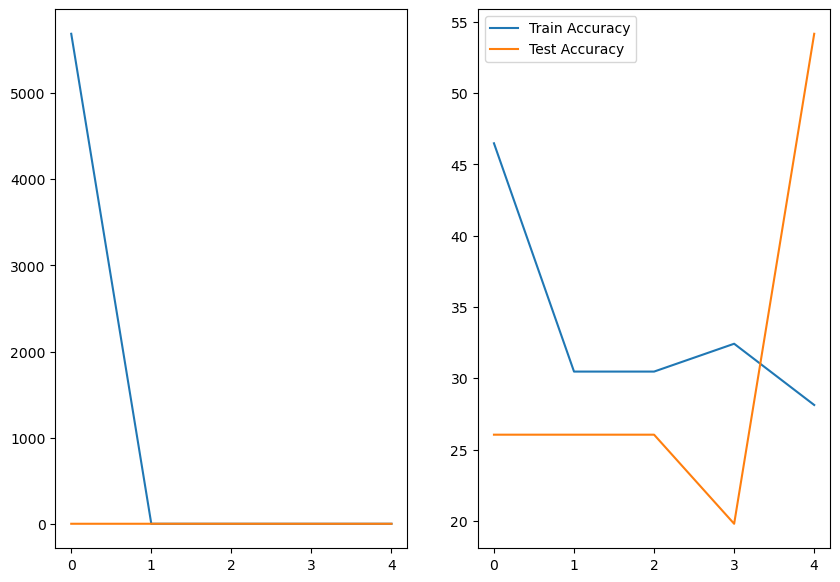

In [41]:
plot_loss_curves(model_0_training)